In [119]:
import pandas as pd

# Load train and test datasets into DataFrames
train_df = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
test_df = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')

# Display the first few rows of each DataFrame to verify the data
print(train_df.head())
print(test_df.head())


   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1  
   id keyword location                                               text
0   0     NaN      NaN                 Just happened a terrible car crash
1   2     NaN      NaN  Heard about #earthquake is different cities, s...
2   3     NaN      NaN  there is a forest fire at spot pond, geese are...
3   9     NaN      NaN           Apocalypse lighting. #Spokane #wildfires
4  11     NaN      NaN      Typhoon Soudelor kills 28 in China and Taiwan


In [120]:
# Filter the train and test DataFrames to only use the 'id' and 'text' columns
train_df_filtered = train_df[['id', 'text', 'target']]
test_df_filtered = test_df[['id', 'text']]

# Display the first few rows of the filtered DataFrames to verify
print(train_df_filtered.head())
print(test_df_filtered.head())


   id                                               text  target
0   1  Our Deeds are the Reason of this #earthquake M...       1
1   4             Forest fire near La Ronge Sask. Canada       1
2   5  All residents asked to 'shelter in place' are ...       1
3   6  13,000 people receive #wildfires evacuation or...       1
4   7  Just got sent this photo from Ruby #Alaska as ...       1
   id                                               text
0   0                 Just happened a terrible car crash
1   2  Heard about #earthquake is different cities, s...
2   3  there is a forest fire at spot pond, geese are...
3   9           Apocalypse lighting. #Spokane #wildfires
4  11      Typhoon Soudelor kills 28 in China and Taiwan


In [121]:
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Function to clean the text
def clean_text(text):
    text = text.lower()  # Convert text to lowercase
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove punctuation and special characters
    text = re.sub(r'\d+', '', text)  # Remove numbers
    return text

# Clean the text in both the train and test datasets
train_df_filtered['text_cleaned'] = train_df_filtered['text'].apply(clean_text)
test_df_filtered['text_cleaned'] = test_df_filtered['text'].apply(clean_text)

# Tokenizing the text
tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(train_df_filtered['text_cleaned'])

# Converting text to sequences
train_sequences = tokenizer.texts_to_sequences(train_df_filtered['text_cleaned'])
test_sequences = tokenizer.texts_to_sequences(test_df_filtered['text_cleaned'])

# Padding the sequences to ensure uniform input size
max_length = 100  # You can experiment with this value
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding='post')
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding='post')

# Display the first few sequences
print(train_padded[:5])


/tmp/ipykernel_36/41583849.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df_filtered['text_cleaned'] = train_df_filtered['text'].apply(clean_text)
/tmp/ipykernel_36/41583849.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df_filtered['text_cleaned'] = test_df_filtered['text'].apply(clean_text)


[[ 109 4375   22    2  820    6   19  240  126 1543 4376   67   39    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [ 178   43  216  634 6555 6556 1332    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0

In [110]:
print(train_df_filtered['target'].value_counts())


target
0    4342
1    3271
Name: count, dtype: int64


In [111]:
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, BatchNormalization
from tensorflow.keras.optimizers import Adam

# Define the model architecture
vocab_size = 10000  # Same as the tokenizer's num_words parameter
embedding_dim = 16
max_length = 100  # This should match the max_length used for padding

model = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_length, embeddings_initializer=HeNormal()),
    Bidirectional(LSTM(64, return_sequences=False, kernel_initializer=HeNormal(), kernel_regularizer=l2(0.01))),  # Add L2 regularization
    Dropout(0.5),
    BatchNormalization(),
    Dense(32, activation='relu', kernel_initializer=HeNormal(), kernel_regularizer=l2(0.01)),  # Add L2 regularization
    Dropout(0.5),
    Dense(1, activation='sigmoid', kernel_initializer=HeNormal(), kernel_regularizer=l2(0.01))  # Add L2 regularization
])

# Adjust the learning rate
optimizer = Adam(learning_rate=0.00001)  # Adjust to a higher value

# Compile the model with binary_crossentropy loss
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Display the model summary
model.summary()


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_16 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_15                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [112]:
print(train_df_filtered['target'].unique())


[1 0]


In [113]:
import numpy as np  # Add this line to import numpy
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping

# Split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(train_padded, train_df_filtered['target'], test_size=0.2, random_state=42)

# Convert the target columns to numpy arrays
y_train = np.array(y_train)
y_val = np.array(y_val)

# Calculate class weights to handle potential class imbalance
class_weights_array = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_df_filtered['target']),
    y=train_df_filtered['target']
)

# Create the class weight dictionary based on the target labels (0 and 1)
class_weights = {0: class_weights_array[0], 1: class_weights_array[1]}

# Early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)


# Train the model on the dataset
history = model.fit(
    X_train, y_train,
    epochs=35,
    batch_size=64,  # You can adjust this as needed
    validation_data=(X_val, y_val),
    class_weight=class_weights,  # Apply class weights to handle class imbalance
    callbacks=[early_stop],  # Early stopping callback
    verbose=2
)



Epoch 1/35
96/96 - 5s - 50ms/step - accuracy: 0.5223 - loss: 11.6079 - val_accuracy: 0.4399 - val_loss: 11.4787
Epoch 2/35
96/96 - 1s - 14ms/step - accuracy: 0.5133 - loss: 11.5568 - val_accuracy: 0.4524 - val_loss: 11.4295
Epoch 3/35
96/96 - 1s - 13ms/step - accuracy: 0.5207 - loss: 11.4849 - val_accuracy: 0.4852 - val_loss: 11.3808
Epoch 4/35
96/96 - 1s - 12ms/step - accuracy: 0.5215 - loss: 11.4261 - val_accuracy: 0.5121 - val_loss: 11.3319
Epoch 5/35
96/96 - 1s - 12ms/step - accuracy: 0.5133 - loss: 11.3726 - val_accuracy: 0.5345 - val_loss: 11.2824
Epoch 6/35
96/96 - 1s - 12ms/step - accuracy: 0.5182 - loss: 11.3087 - val_accuracy: 0.5496 - val_loss: 11.2324
Epoch 7/35
96/96 - 1s - 12ms/step - accuracy: 0.5222 - loss: 11.2546 - val_accuracy: 0.5640 - val_loss: 11.1823
Epoch 8/35
96/96 - 1s - 12ms/step - accuracy: 0.5310 - loss: 11.1981 - val_accuracy: 0.5791 - val_loss: 11.1325
Epoch 9/35
96/96 - 1s - 12ms/step - accuracy: 0.5281 - loss: 11.1410 - val_accuracy: 0.5923 - val_loss: 

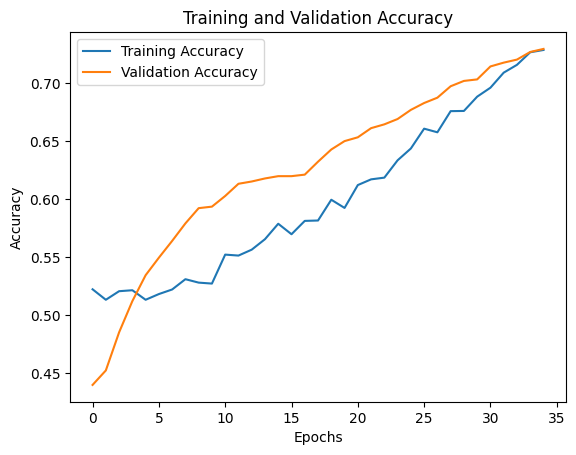

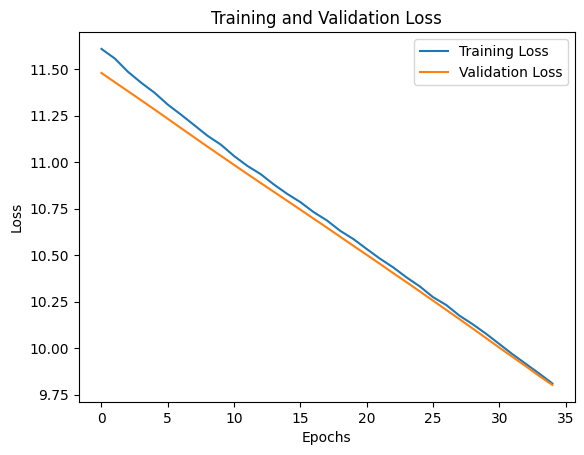

In [114]:
import matplotlib.pyplot as plt

# Plot accuracy over epochs
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Plot loss over epochs
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [115]:
# Tokenize and pad the test data
test_sequences = tokenizer.texts_to_sequences(test_df_filtered['text_cleaned'])  # Ensure you have cleaned the text the same way
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding='post')

# Predict using the trained model
predictions = model.predict(test_padded)

# Convert predictions to binary output (0 or 1)
predicted_labels = (predictions > 0.5).astype(int)  # Since it’s a binary classification, threshold is 0.5


102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


In [116]:
# Create a DataFrame with the ID and predicted target
submission_df = pd.DataFrame({
    'id': test_df_filtered['id'],  # Use the ID from the test dataset
    'target': predicted_labels.flatten()  # Flatten if needed, so it's in the correct shape
})

# Save the submission file as a CSV
submission_df.to_csv('submission.csv', index=False)

print("Submission file created successfully!")


Submission file created successfully!


In [214]:
import pandas as pd

# Load train and test datasets into DataFrames
train_df = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
test_df = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')

# Display the first few rows of each DataFrame to verify the data
print(train_df.head())
print(test_df.head())


   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1  
   id keyword location                                               text
0   0     NaN      NaN                 Just happened a terrible car crash
1   2     NaN      NaN  Heard about #earthquake is different cities, s...
2   3     NaN      NaN  there is a forest fire at spot pond, geese are...
3   9     NaN      NaN           Apocalypse lighting. #Spokane #wildfires
4  11     NaN      NaN      Typhoon Soudelor kills 28 in China and Taiwan


In [215]:
# Filter the train and test DataFrames to only use the 'id' and 'text' columns
train_df_filtered = train_df[['id', 'text', 'target']]
test_df_filtered = test_df[['id', 'text']]

# Display the first few rows of the filtered DataFrames to verify
print(train_df_filtered.head())
print(test_df_filtered.head())


   id                                               text  target
0   1  Our Deeds are the Reason of this #earthquake M...       1
1   4             Forest fire near La Ronge Sask. Canada       1
2   5  All residents asked to 'shelter in place' are ...       1
3   6  13,000 people receive #wildfires evacuation or...       1
4   7  Just got sent this photo from Ruby #Alaska as ...       1
   id                                               text
0   0                 Just happened a terrible car crash
1   2  Heard about #earthquake is different cities, s...
2   3  there is a forest fire at spot pond, geese are...
3   9           Apocalypse lighting. #Spokane #wildfires
4  11      Typhoon Soudelor kills 28 in China and Taiwan


In [204]:
import keras_nlp
import keras
from tensorflow.keras.optimizers import Adam

# Define some hyperparameters
preset = "distil_bert_base_en_uncased"
sequence_length = 160
BATCH_SIZE = 16
EPOCHS = 3

# Load a DistilBERT preprocessor with a sequence length of 160
preprocessor = keras_nlp.models.DistilBertPreprocessor.from_preset(
    preset,
    sequence_length=sequence_length,
    name="preprocessor_4_tweets"
)

In [217]:
# Function to preprocess text
import re

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'\@w+|\#', '', text)
    text = re.sub(r'[^A-Za-z0-9\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Apply preprocessing to training and test data
train_df_filtered['text_cleaned'] = train_df_filtered['text'].apply(preprocess_text)
test_df_filtered['text_cleaned'] = test_df_filtered['text'].apply(preprocess_text)

# Function to tokenize the text using DistilBERT tokenizer
def encode_data(texts, tokenizer, max_length=128):
    encoded = tokenizer.batch_encode_plus(
        texts.tolist(),  # Convert the text column to a list
        add_special_tokens=True,  # Add [CLS] and [SEP] tokens
        max_length=max_length,  # Max sequence length
        padding='max_length',  # Pad sequences to max_length
        truncation=True,  # Truncate longer sequences
        return_attention_mask=True,  # Return attention mask
        return_tensors='tf'  # Return TensorFlow tensors
    )
    return encoded['input_ids'], encoded['attention_mask']

# Tokenize the training and test data
X_train_input_ids, X_train_attention_mask = encode_data(train_df_filtered['text_cleaned'], tokenizer)
X_test_input_ids, X_test_attention_mask = encode_data(test_df_filtered['text_cleaned'], tokenizer)

# Display the shape of the tokenized data to verify
print(X_train_input_ids.shape)
print(X_test_input_ids.shape)


/tmp/ipykernel_36/770770621.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df_filtered['text_cleaned'] = train_df_filtered['text'].apply(preprocess_text)
/tmp/ipykernel_36/770770621.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df_filtered['text_cleaned'] = test_df_filtered['text'].apply(preprocess_text)


(7613, 128)
(3263, 128)


In [206]:
train_df_filtered = train_df_filtered.iloc[:len(y_train)]


In [207]:
# Load the DistilBERT classifier with 2 output classes for binary classification
classifier = keras_nlp.models.DistilBertClassifier.from_preset(
    preset,
    preprocessor=preprocessor,
    num_classes=2
)

# Display model summary
classifier.summary()

# Compile the model
classifier.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),  # Suitable for integer labels
    optimizer=Adam(learning_rate=1e-5),
    metrics=["accuracy"]
)

Preprocessor: "preprocessor_4_tweets"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Tokenizer (type)                                   ┃                                             Vocab # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ distil_bert_tokenizer (DistilBertTokenizer)        │                                              30,522 │
└────────────────────────────────────────────────────┴─────────────────────────────────────────────────────┘

Model: "distil_bert_classifier_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ distil_bert_backbone          │ (None, None, 768)         │      66,362,880 │ padding_mask[0][0],        │
│ (DistilBertBackbone)          │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ get_item_7 (GetItem)          │ (None, 768)               │               0 │ distil_bert_backbone[0][0] │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pooled_dense (Dense)          │ (None, 768)               │         590,592 │ get_item_7[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ output_dropout (Dropout)      │ (None, 768)               │               0 │ pooled_dense[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ logits (Dense)                │ (None, 2)                 │           1,538 │ output_dropout[0][0]       │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 66,955,010 (255.41 MB)

 Trainable params: 66,955,010 (255.41 MB)

 Non-trainable params: 0 (0.00 B)

In [208]:
print(len(train_df_filtered['text_cleaned']))
print(len(y_train))


3897
3897


In [209]:
from sklearn.model_selection import train_test_split

# Split the training data into training and validation sets
X_train_texts, X_val_texts, y_train, y_val = train_test_split(
    train_df_filtered['text_cleaned'], y_train, test_size=0.2, random_state=42
)

# Train the model using raw text (no need for manual tokenization)
history = classifier.fit(
    x=X_train_texts,  # Use the cleaned text directly for training
    y=y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_val_texts, y_val)  # Use the validation data split from training set
)


Epoch 1/3
194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - accuracy: 0.5656 - loss: 0.6856

I0000 00:00:1726371004.655196    4573 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_235', 8 bytes spill stores, 8 bytes spill loads

I0000 00:00:1726371004.907163    4572 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_247', 16 bytes spill stores, 8 bytes spill loads

I0000 00:00:1726371007.343968    4570 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_235', 1256 bytes spill stores, 1212 bytes spill loads

I0000 00:00:1726371029.389325     116 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_44', 80 bytes spill stores, 80 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_33', 4 bytes spill stores, 4 bytes spill loads



195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step - accuracy: 0.5656 - loss: 0.6856

I0000 00:00:1726371038.872873    4610 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_43', 8 bytes spill stores, 8 bytes spill loads

I0000 00:00:1726371041.179065    4611 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_43', 968 bytes spill stores, 924 bytes spill loads



195/195 ━━━━━━━━━━━━━━━━━━━━ 154s 511ms/step - accuracy: 0.5656 - loss: 0.6856 - val_accuracy: 0.5526 - val_loss: 0.6907
Epoch 2/3
195/195 ━━━━━━━━━━━━━━━━━━━━ 41s 208ms/step - accuracy: 0.5683 - loss: 0.6797 - val_accuracy: 0.5526 - val_loss: 0.6939
Epoch 3/3
195/195 ━━━━━━━━━━━━━━━━━━━━ 41s 211ms/step - accuracy: 0.5741 - loss: 0.6674 - val_accuracy: 0.5449 - val_loss: 0.7053


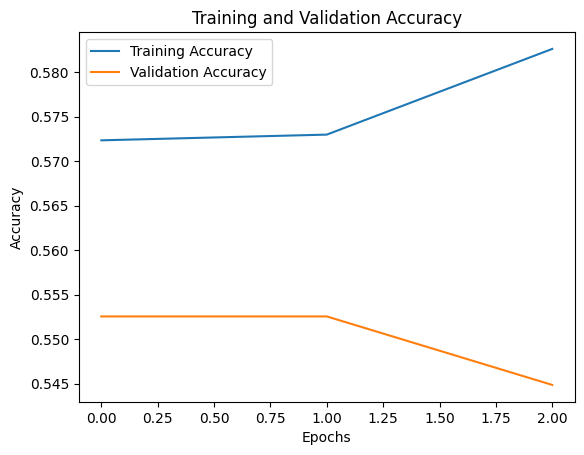

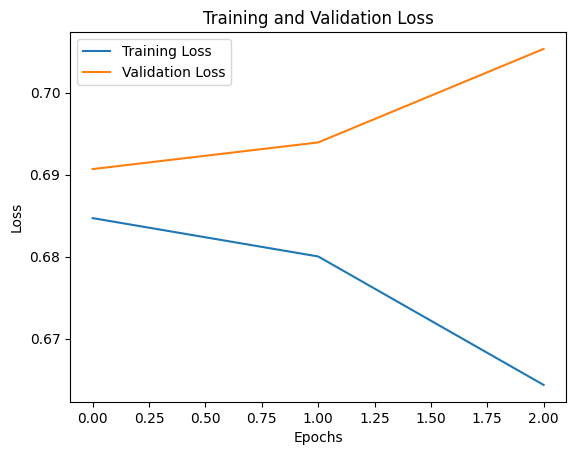

In [210]:
import matplotlib.pyplot as plt

# Plot the training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 208ms/step


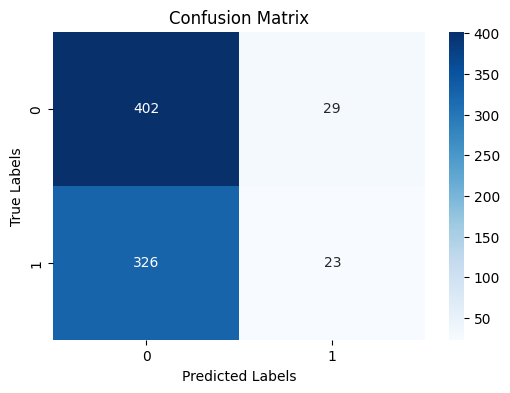

In [211]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Predict the validation data
y_val_pred = classifier.predict(X_val_texts)
y_val_pred_labels = y_val_pred.argmax(axis=1)  # Get the predicted labels

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_val, y_val_pred_labels)

# Plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


In [212]:
# Predict the test data (X_test_texts is the raw text from the test set)
y_test_pred = classifier.predict(test_df_filtered['text_cleaned'])
y_test_pred_labels = y_test_pred.argmax(axis=1)  # Get the predicted labels

# Create a submission file
submission_df = test_df_filtered[['id']].copy()
submission_df['target'] = y_test_pred_labels

# Save the submission file
submission_df.to_csv('submission.csv', index=False)


102/102 ━━━━━━━━━━━━━━━━━━━━ 15s 141ms/step


In [254]:
# Filter the train and test DataFrames to only use the 'id' and 'text' columns
train_df_filtered = train_df[['id', 'text', 'target']]
test_df_filtered = test_df[['id', 'text']]

# Display the first few rows of the filtered DataFrames to verify
print(train_df_filtered.head())
print(test_df_filtered.head())
# Filter the train and test DataFrames to only use the 'id' and 'text' columns
train_df_filtered = train_df[['id', 'text', 'target']]
test_df_filtered = test_df[['id', 'text']]

# Display the first few rows of the filtered DataFrames to verify
print(train_df_filtered.head())
print(test_df_filtered.head())
# Function to preprocess text
import re

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'\@w+|\#', '', text)
    text = re.sub(r'[^A-Za-z0-9\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Apply preprocessing to training and test data
train_df_filtered['text_cleaned'] = train_df_filtered['text'].apply(preprocess_text)
test_df_filtered['text_cleaned'] = test_df_filtered['text'].apply(preprocess_text)

# Function to tokenize the text using DistilBERT tokenizer
def encode_data(texts, tokenizer, max_length=128):
    encoded = tokenizer.batch_encode_plus(
        texts.tolist(),  # Convert the text column to a list
        add_special_tokens=True,  # Add [CLS] and [SEP] tokens
        max_length=max_length,  # Max sequence length
        padding='max_length',  # Pad sequences to max_length
        truncation=True,  # Truncate longer sequences
        return_attention_mask=True,  # Return attention mask
        return_tensors='tf'  # Return TensorFlow tensors
    )
    return encoded['input_ids'], encoded['attention_mask']

# Tokenize the training and test data
X_train_input_ids, X_train_attention_mask = encode_data(train_df_filtered['text_cleaned'], tokenizer)
X_test_input_ids, X_test_attention_mask = encode_data(test_df_filtered['text_cleaned'], tokenizer)

# Display the shape of the tokenized data to verify
print(X_train_input_ids.shape)
print(X_test_input_ids.shape)


   id                                               text  target
0   1  Our Deeds are the Reason of this #earthquake M...       1
1   4             Forest fire near La Ronge Sask. Canada       1
2   5  All residents asked to 'shelter in place' are ...       1
3   6  13,000 people receive #wildfires evacuation or...       1
4   7  Just got sent this photo from Ruby #Alaska as ...       1
   id                                               text
0   0                 Just happened a terrible car crash
1   2  Heard about #earthquake is different cities, s...
2   3  there is a forest fire at spot pond, geese are...
3   9           Apocalypse lighting. #Spokane #wildfires
4  11      Typhoon Soudelor kills 28 in China and Taiwan
   id                                               text  target
0   1  Our Deeds are the Reason of this #earthquake M...       1
1   4             Forest fire near La Ronge Sask. Canada       1
2   5  All residents asked to 'shelter in place' are ...       1
3   6  1

/tmp/ipykernel_36/228872697.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df_filtered['text_cleaned'] = train_df_filtered['text'].apply(preprocess_text)
/tmp/ipykernel_36/228872697.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df_filtered['text_cleaned'] = test_df_filtered['text'].apply(preprocess_text)


(7613, 128)
(3263, 128)


In [255]:
from transformers import TFBertForSequenceClassification, BertTokenizer
import tensorflow as tf

# Load pre-trained BERT model for binary classification
bert_model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)


All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [257]:
from sklearn.model_selection import train_test_split
import tensorflow as tf

# Convert TensorFlow tensors to numpy arrays
X_train_input_ids_np = X_train_input_ids.numpy()
X_train_attention_mask_np = X_train_attention_mask.numpy()

# Now split the numpy arrays
X_train_input_ids_np, X_val_input_ids_np, X_train_attention_mask_np, X_val_attention_mask_np, y_train, y_val = train_test_split(
    X_train_input_ids_np, X_train_attention_mask_np, train_df_filtered['target'], test_size=0.2, random_state=42
)

# Convert target variables to TensorFlow tensors
y_train = tf.convert_to_tensor(y_train.values)
y_val = tf.convert_to_tensor(y_val.values)

# If needed, convert the numpy arrays back to TensorFlow tensors
X_train_input_ids = tf.convert_to_tensor(X_train_input_ids_np)
X_val_input_ids = tf.convert_to_tensor(X_val_input_ids_np)
X_train_attention_mask = tf.convert_to_tensor(X_train_attention_mask_np)
X_val_attention_mask = tf.convert_to_tensor(X_val_attention_mask_np)


In [259]:
import tensorflow as tf
from transformers import TFBertForSequenceClassification
import numpy as np

# Load the pre-trained BERT model for sequence classification
bert_model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Define optimizer and loss function
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# Prepare dataset
train_dataset = tf.data.Dataset.from_tensor_slices((
    {'input_ids': X_train_input_ids, 'attention_mask': X_train_attention_mask},
    y_train
)).shuffle(100).batch(16)

val_dataset = tf.data.Dataset.from_tensor_slices((
    {'input_ids': X_val_input_ids, 'attention_mask': X_val_attention_mask},
    y_val
)).batch(16)

# Training loop
epochs = 3

for epoch in range(epochs):
    print(f'Epoch {epoch + 1}/{epochs}')
    for step, (inputs, labels) in enumerate(train_dataset):
        with tf.GradientTape() as tape:
            logits = bert_model(inputs, training=True).logits
            loss = loss_fn(labels, logits)
        
        # Backpropagation
        gradients = tape.gradient(loss, bert_model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, bert_model.trainable_variables))
        
        if step % 50 == 0:
            print(f'Step {step}, Loss: {loss.numpy()}')

    # Validation
    val_loss = []
    val_acc = []
    for inputs, labels in val_dataset:
        val_logits = bert_model(inputs, training=False).logits
        val_loss.append(loss_fn(labels, val_logits).numpy())
        
        # Calculate accuracy
        predictions = np.argmax(val_logits, axis=-1)
        accuracy = np.mean(predictions == labels.numpy())
        val_acc.append(accuracy)
    
    print(f'Validation Loss: {np.mean(val_loss)}, Validation Accuracy: {np.mean(val_acc)}')

# You can now save the model if needed
bert_model.save_pretrained('./my_bert_model')


All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3
Step 0, Loss: 0.7257117033004761
Step 50, Loss: 0.32379549741744995
Step 100, Loss: 0.5901700854301453
Step 150, Loss: 0.3591991066932678
Step 200, Loss: 0.5378755927085876
Step 250, Loss: 0.21795788407325745
Step 300, Loss: 0.7024459838867188
Step 350, Loss: 0.19058001041412354
Validation Loss: 0.3914768397808075, Validation Accuracy: 0.833984375
Epoch 2/3
Step 0, Loss: 0.3465873599052429
Step 50, Loss: 0.3870195746421814
Step 100, Loss: 0.33429574966430664
Step 150, Loss: 0.4913404881954193
Step 200, Loss: 0.27814197540283203
Step 250, Loss: 0.26421257853507996
Step 300, Loss: 0.25077080726623535
Step 350, Loss: 0.4274755120277405
Validation Loss: 0.4274895191192627, Validation Accuracy: 0.8385416666666666
Epoch 3/3
Step 0, Loss: 0.39084333181381226
Step 50, Loss: 0.06808947026729584
Step 100, Loss: 0.2792763113975525
Step 150, Loss: 0.33486196398735046
Step 200, Loss: 0.286416232585907
Step 250, Loss: 0.053726159036159515
Step 300, Loss: 0.22849257290363312
Step 350, Loss:

In [266]:
from transformers import TFBertForSequenceClassification
import numpy as np

# Load the saved model
loaded_model = TFBertForSequenceClassification.from_pretrained('./my_bert_model')

# Prepare validation dataset
val_dataset = tf.data.Dataset.from_tensor_slices((
    {'input_ids': X_val_input_ids, 'attention_mask': X_val_attention_mask},
    y_val
)).batch(16)

# Evaluate on validation set
val_loss = []
val_acc = []
for inputs, labels in val_dataset:
    val_logits = loaded_model(inputs, training=False).logits
    val_loss.append(loss_fn(labels, val_logits).numpy())
    
    # Calculate accuracy
    predictions = np.argmax(val_logits, axis=-1)
    accuracy = np.mean(predictions == labels.numpy())
    val_acc.append(accuracy)

# Print the final validation loss and accuracy
print(f'Validation Loss: {np.mean(val_loss)}, Validation Accuracy: {np.mean(val_acc)}')

# Optionally, you can plot the metrics like before if you have metrics for all epochs


Some layers from the model checkpoint at ./my_bert_model were not used when initializing TFBertForSequenceClassification: ['dropout_834']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at ./my_bert_model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


Validation Loss: 0.4969790279865265, Validation Accuracy: 0.8313802083333334


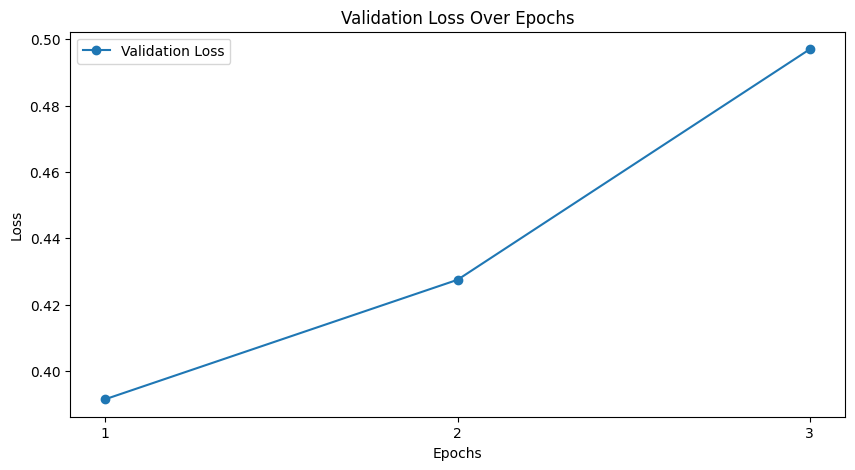

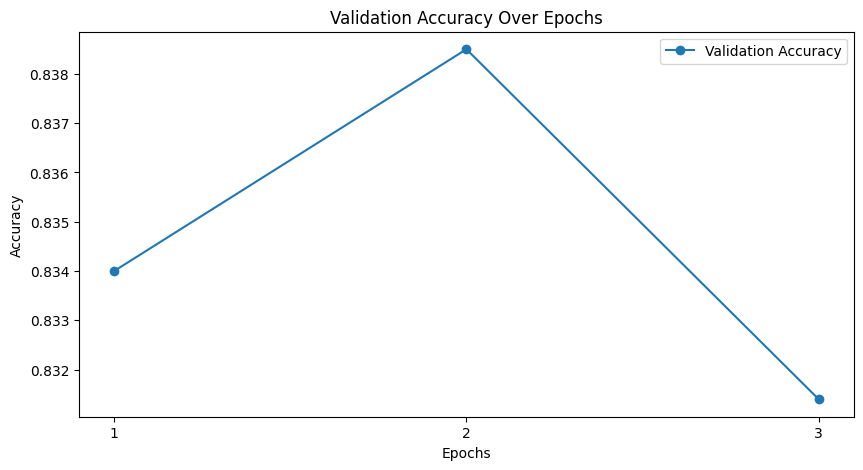

In [268]:
import matplotlib.pyplot as plt

# Extracted data from your logs
val_loss_values = [0.3915, 0.4275, 0.4970]
val_acc_values = [0.8340, 0.8385, 0.8314]

# Plot Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, 4), val_loss_values, label='Validation Loss', marker='o')
plt.title('Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(range(1, 4))
plt.legend()
plt.show()

# Plot Validation Accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, 4), val_acc_values, label='Validation Accuracy', marker='o')
plt.title('Validation Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xticks(range(1, 4))
plt.legend()
plt.show()


In [261]:
# Make predictions on the test dataset
test_dataset = tf.data.Dataset.from_tensor_slices({
    'input_ids': X_test_input_ids,
    'attention_mask': X_test_attention_mask
}).batch(16)

# Get predicted logits from the trained model
test_logits = bert_model.predict(test_dataset).logits

# Convert logits to class labels (0 or 1 for binary classification)
test_predictions = tf.argmax(test_logits, axis=-1).numpy()

# Prepare the submission DataFrame
submission_df = pd.DataFrame({
    'id': test_df_filtered['id'],
    'target': test_predictions
})

# Save the submission DataFrame as a CSV file
submission_df.to_csv('submission.csv', index=False)
print("Submission file created successfully!")


204/204 [==============================] - 49s 131ms/step
Submission file created successfully!
